In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

<h3> Experiment for Explore-then-Exploit

In [3]:
k = 5                                                 # number of arms
user_types = ("female over 25", "male over 25" , "male under 25", "female under 25")  # possible different types of users
U = len(user_types)                                   # amount of different users
T = 1000                                              # horizon
N = int(np.power((T*k**2*np.log10(T))/U**2 , 1/3))    # explore rounds

print("N =",N)
print(N*k*U) # exploration rounds

# click probabilities
true_click_probs = np.array([
    [0.8, 0.6, 0.5, 0.4, 0.2],      # female over 25
    [0.2, 0.4, 0.5, 0.6, 0.8],      # male over 25
    [0.2, 0.4, 0.8, 0.6, 0.5],      # male under 25
    [0.2, 0.4, 0.8, 0.6, 0.5]       # female under 25 (similar preferences)
    ])
best_article_list = [np.amax(us) for us in true_click_probs] # get the best possible arm for each user

N = 16
320


In [4]:
bandit_score = np.zeros((U,k))                 # total score of each arm for first N rounds
pulls = np.zeros((k,))                         # num of arm pulls
inst_score = np.zeros((U,T))                   # reward for round t
best_score = np.zeros((U,T))                   # cumulative reward of best arm for round t
alg_score = np.zeros((U,T))                    # cumulative reward for round t
regret =  np.zeros((U,T))                      # regret for round t
cumulative_regret =  np.zeros((U,T))           # cumulative regret for round t

In [6]:
# EXPLORATION PHASE: For each user show all articles and add up the score for N rounds.
count = 0
for user in range(U): # for each user 
    for i in range(N): # for N rounds 
        for j in range(k): # show each article
            count+=1 # count checking 
            current_user_chances = true_click_probs[user] # get current user's probabilities
        
            #print(f"Current User: {user} ({user_types[user]}) with chances {user} with j : {j}")
        
            score = np.random.binomial(1,p=current_user_chances[j])  # get a reward for arm j for current user
            inst_score[user][i*k+j] = score                          # record reward of algorithm (during explore) at that instant for current user
            bandit_score[user][j] += score                           # update the total score (during explore) of arm j for current user
print(count)

# display the true mean and the sample mean for each user's article
for i, user in enumerate(user_types):
  print(f'{user} with index : {i}')
  for j in range(k):
    print(f'article = {j}: true mean = {true_click_probs[i][j]} : sample mean = {bandit_score[i][j]/N}')
  print()

# show the best 'arm' article for each user 
articles = []
for i, user in enumerate(user_types):
  article = np.argmax(bandit_score[i]/N)  #get id of best arm (during explore)
  articles.append(article)
  print(f'For {user} the best article is: {article}')

320
female over 25 with index : 0
article = 0: true mean = 0.8 : sample mean = 1.625
article = 1: true mean = 0.6 : sample mean = 1.3125
article = 2: true mean = 0.5 : sample mean = 1.4375
article = 3: true mean = 0.4 : sample mean = 0.5
article = 4: true mean = 0.2 : sample mean = 0.3125

male over 25 with index : 1
article = 0: true mean = 0.2 : sample mean = 0.4375
article = 1: true mean = 0.4 : sample mean = 0.75
article = 2: true mean = 0.5 : sample mean = 1.0625
article = 3: true mean = 0.6 : sample mean = 1.0
article = 4: true mean = 0.8 : sample mean = 1.6875

male under 25 with index : 2
article = 0: true mean = 0.2 : sample mean = 0.25
article = 1: true mean = 0.4 : sample mean = 0.9375
article = 2: true mean = 0.8 : sample mean = 1.375
article = 3: true mean = 0.6 : sample mean = 1.4375
article = 4: true mean = 0.5 : sample mean = 0.625

female under 25 with index : 3
article = 0: true mean = 0.2 : sample mean = 0.25
article = 1: true mean = 0.4 : sample mean = 0.8125
articl

In [7]:
# EXPLOITATION PHASE: After N*K*U, play the best "arm" for each user.
for i in range(N*k*U,T):
    current_user = np.random.randint(U)                             # get random user
    current_user_chances = true_click_probs[current_user]           # get their probabilities
    article = articles[current_user]                                # get their best arm
    inst_score[current_user][i] = np.random.binomial(1,p=current_user_chances[article])  # play best arm for each user for the remainder of the horizon

In [8]:
for i in range(T):
    current_user = np.random.randint(U)                             # get random user
    if i > 0:
        best_score[current_user][i] = best_score[current_user][i-1] + best_article_list[current_user] # vector keeping track of t*optimal reward (cummulative reward)
    else:
        best_score[current_user][i] = best_article_list[current_user]
    #print(best_score[current_user])
    if i > 0: 
        alg_score[current_user][i] = alg_score[current_user][i-1] + inst_score[current_user][i] #vector keeping track of cummulative explore-then-eploit reward at all times 
    else:
        alg_score[current_user][i] = inst_score[current_user][i]

    # regret can't be negative
    regret[current_user][i] = max((best_score[current_user][i] - alg_score[current_user][i])/(i+1),0)             # regret per iteration at round t
    cumulative_regret[current_user][i] = max(best_score[current_user][i] - alg_score[current_user][i], 0)


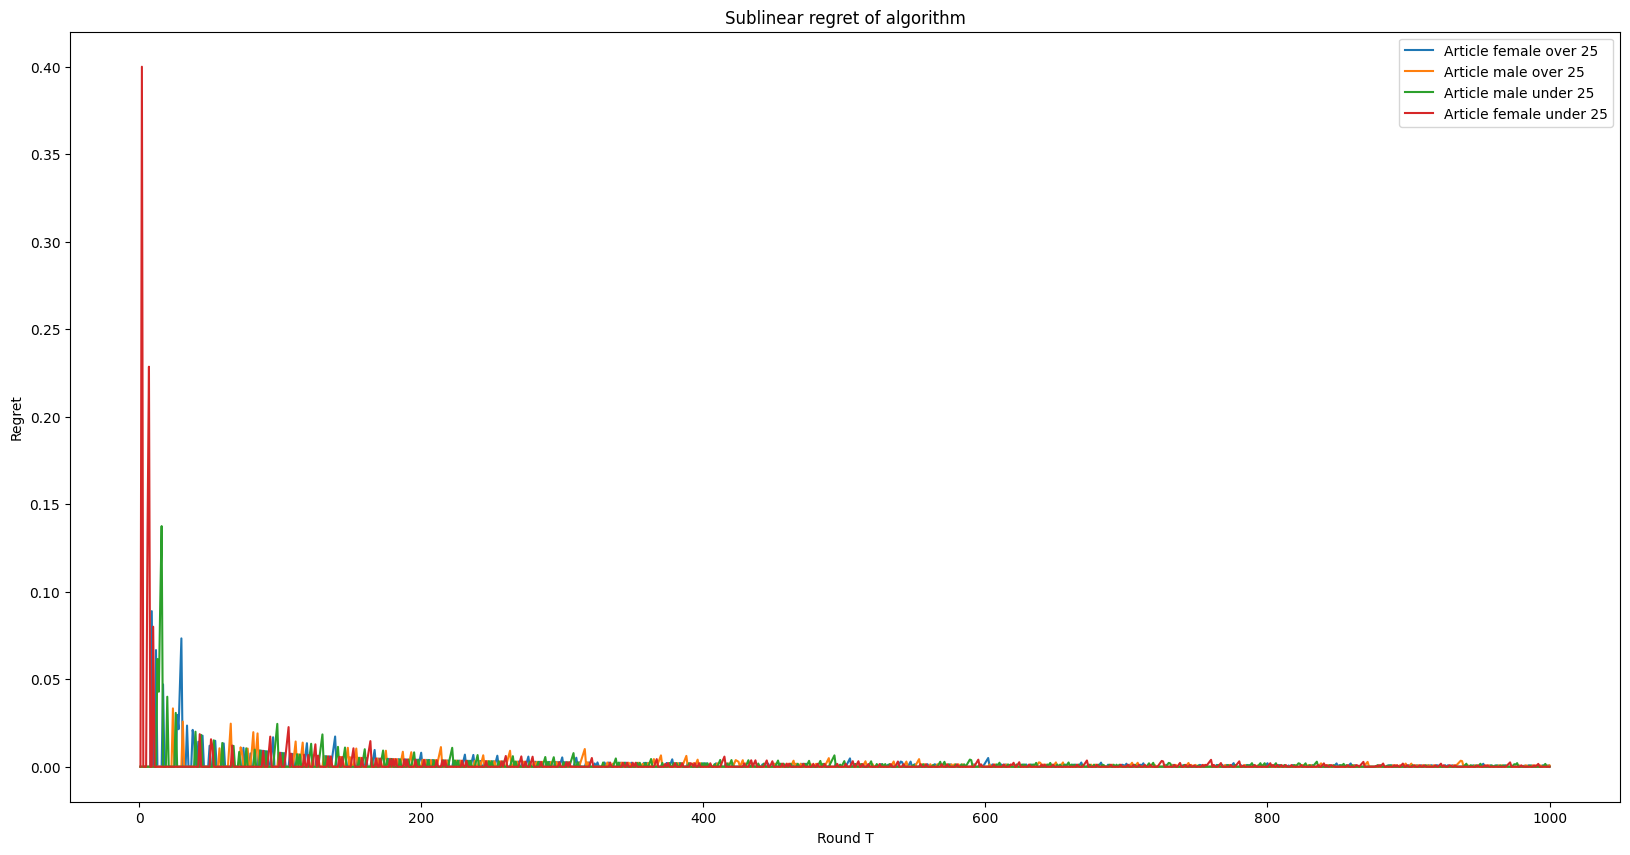

In [9]:
# plot the regret of the UCB algorithm 
plt.figure(figsize=(20, 10))
for current_user in range(len(user_types)):
    plt.plot(np.arange(1,T+1), regret[current_user], label=f'Article {user_types[current_user]}')
plt.title("Sublinear regret of algorithm") 
plt.xlabel("Round T") 
plt.ylabel("Regret") 
plt.legend()
plt.show()

In [10]:
# get the theoretical upper bound for regret
def get_upper_bound(t): 
    return (t**(1/3) * k**(5/3) * np.log10(t)**(1/3) / U**(1/3)) + (t * np.sqrt(U**(2/3) / (t**(1/3) * k**(2/3))))
regret_upper_bound = np.zeros((T,))
for i in np.arange(1, T):
    regret_upper_bound[i] = get_upper_bound(i)

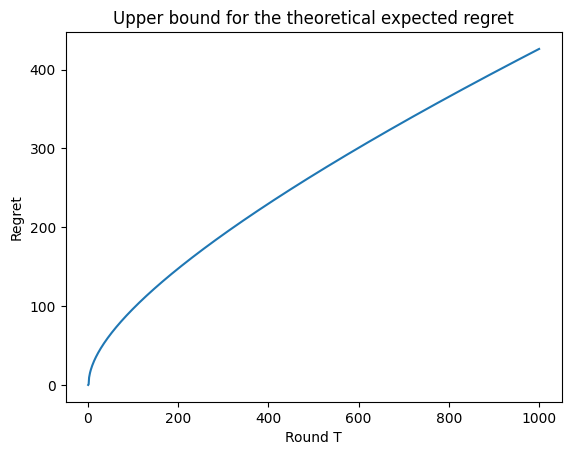

In [11]:
#plt.plot(np.arange(1,T+1), regret[current_user], label=f'Article {user_types[current_user]}')
plt.plot(np.arange(1,T+1), regret_upper_bound, label=f'Upper Bound')
plt.title("Upper bound for the theoretical expected regret") 
plt.xlabel("Round T") 
plt.ylabel("Regret") 
plt.show()

In [12]:
# different plot for every user
# for current_user in range(U):
#     plt.figure(figsize=(18, 6))
#     plt.plot(np.arange(1,T+1), regret[current_user], label=f'Article {user_types[current_user]}')
#     plt.title("Sublinear regret of algorithm") 
#     plt.xlabel("Round T") 
#     plt.ylabel("Regret") 
#     plt.legend()
#     plt.show()

<h3> Repeating the experiment for horizon T = 10000 and compare to the previous one.

In [14]:
# reinitialize for T = 10000
T = 10000 # horizon
N = int(np.power((T*k**2*np.log10(T))/U**2 , 1/3))    # explore rounds
print(N)
print(N*k*U)                                   # printing new exploration rounds
bandit_score = np.zeros((U,k))                 # total score of each arm for first N rounds
pulls = np.zeros((k,))                         # num of arm pulls
inst_score = np.zeros((U,T))                   # reward for round t
best_score = np.zeros((U,T))                   # cumulative reward of best arm for round t
alg_score = np.zeros((U,T))                    # cumulative reward for round t
regret =  np.zeros((U,T))                      # regret for round t
cumulative_regret =  np.zeros((U,T))           # cumulative regret for round t

39
780


In [15]:
# EXPLORATION PHASE: For each user show all articles and add up the score for N rounds.
count = 0
for user in range(U): # for each user
    for i in range(N): # for N rounds
        for j in range(k): # show each article
            count+=1 # count checking 
            current_user_chances = true_click_probs[user] # get current user's probabilities
        
            #print(f"Current User: {user} ({user_types[user]}) with chances {user} with j : {j}")
        
            score = np.random.binomial(1,p=current_user_chances[j])  # get a reward for arm j for current user
            inst_score[user][i*k+j] = score                          # record reward of algorithm (during explore) at that instant for current user
            bandit_score[user][j] += score                           # update the total score (during explore) of arm j for current user
print(count)

# display the true mean and the sample mean for each user's article
for i, user in enumerate(user_types):
  print(f'{user} with index : {i}')
  for j in range(k):
    print(f'article = {j}: true mean = {true_click_probs[i][j]} : sample mean = {bandit_score[i][j]/N}')
  print()

# show the best 'arm' article for each user 
articles = []
for i, user in enumerate(user_types):
  article = np.argmax(bandit_score[i]/N)  #get id of best arm (during explore)
  articles.append(article)
  print(f'For {user} the best article is: {article}')

# EXPLOITATION PHASE: After N*K*U, play the best "arm" for each user.
for i in range(N*k*U,T):
    current_user = np.random.randint(U)                             # get random user
    current_user_chances = true_click_probs[current_user]           # get their probabilities
    article = articles[current_user]                                # get their best arm
    inst_score[current_user][i] = np.random.binomial(1,p=current_user_chances[article])  # play best arm for each user for the remainder of the horizon

for i in range(T):
    current_user = np.random.randint(U)                             # get random user
    if i > 0:
        best_score[current_user][i] = best_score[current_user][i-1] + best_article_list[current_user] # vector keeping track of t*optimal reward (cummulative reward)
    else:
        best_score[current_user][i] = best_article_list[current_user]
    #print(best_score[current_user])
    if i > 0: 
        alg_score[current_user][i] = alg_score[current_user][i-1] + inst_score[current_user][i] #vector keeping track of cummulative explore-then-eploit reward at all times 
    else:
        alg_score[current_user][i] = inst_score[current_user][i]

    # regret can't be negative
    regret[current_user][i] = max((best_score[current_user][i] - alg_score[current_user][i])/(i+1),0)             # regret per iteration at round t
    cumulative_regret[current_user][i] = max(best_score[current_user][i] - alg_score[current_user][i], 0)


780
female over 25 with index : 0
article = 0: true mean = 0.8 : sample mean = 0.7948717948717948
article = 1: true mean = 0.6 : sample mean = 0.5384615384615384
article = 2: true mean = 0.5 : sample mean = 0.4358974358974359
article = 3: true mean = 0.4 : sample mean = 0.3076923076923077
article = 4: true mean = 0.2 : sample mean = 0.2564102564102564

male over 25 with index : 1
article = 0: true mean = 0.2 : sample mean = 0.3333333333333333
article = 1: true mean = 0.4 : sample mean = 0.4358974358974359
article = 2: true mean = 0.5 : sample mean = 0.6153846153846154
article = 3: true mean = 0.6 : sample mean = 0.6410256410256411
article = 4: true mean = 0.8 : sample mean = 0.7435897435897436

male under 25 with index : 2
article = 0: true mean = 0.2 : sample mean = 0.1794871794871795
article = 1: true mean = 0.4 : sample mean = 0.20512820512820512
article = 2: true mean = 0.8 : sample mean = 0.8205128205128205
article = 3: true mean = 0.6 : sample mean = 0.5641025641025641
article = 

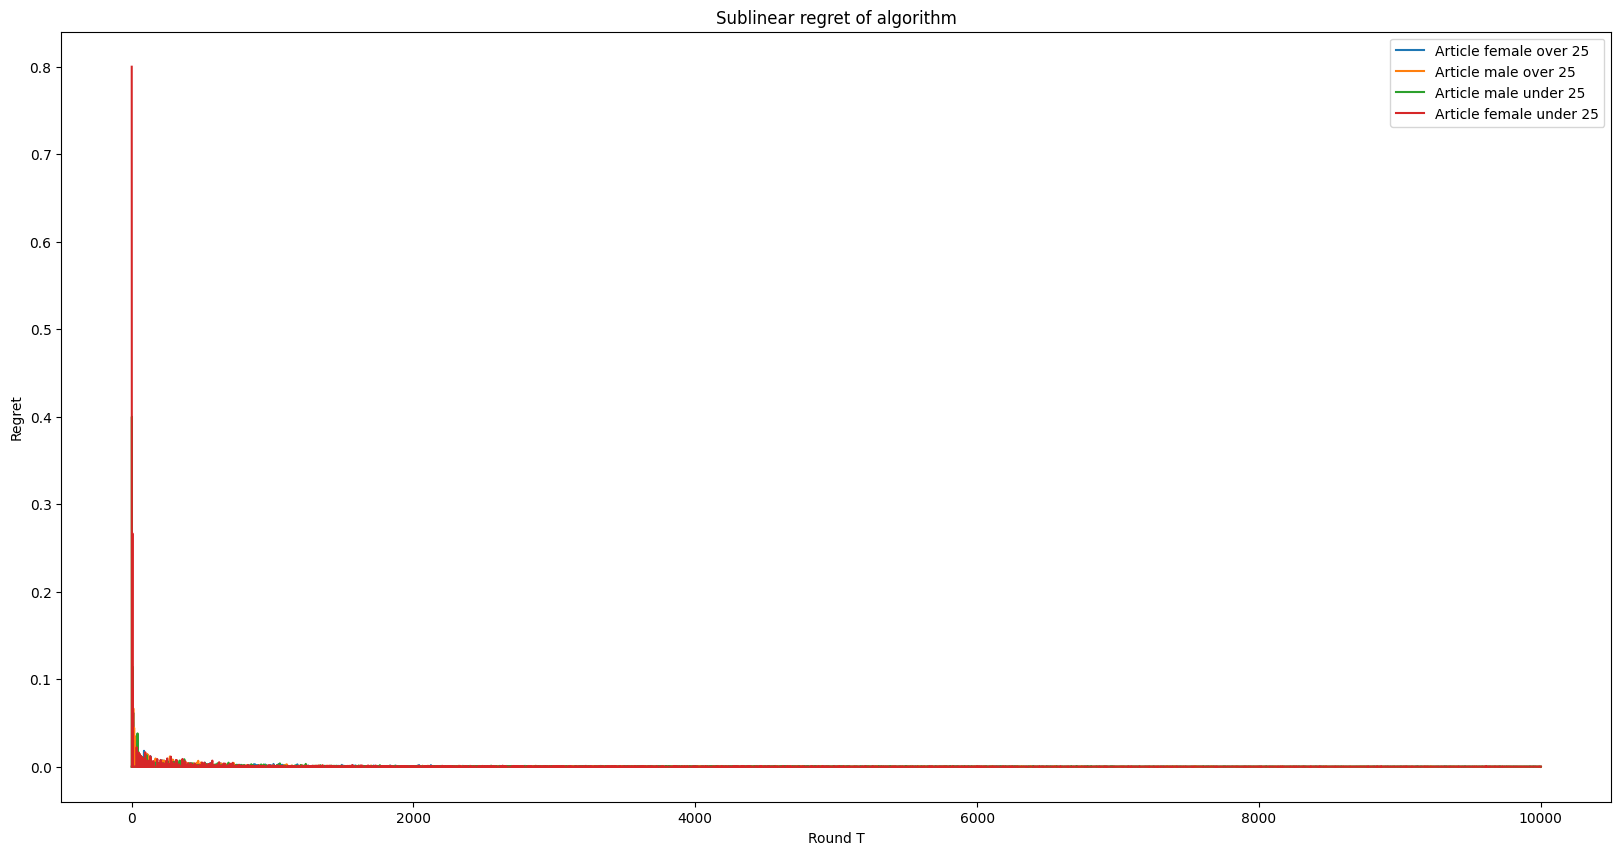

In [16]:
# plot the regret of the UCB algorithm 
plt.figure(figsize=(20, 10))
for current_user in range(len(user_types)):
    plt.plot(np.arange(1,T+1), regret[current_user], label=f'Article {user_types[current_user]}')
plt.title("Sublinear regret of algorithm") 
plt.xlabel("Round T") 
plt.ylabel("Regret") 
plt.legend()
plt.show()

In [17]:
regret_upper_bound = np.zeros((T,))
for i in np.arange(1, T):
    regret_upper_bound[i] = get_upper_bound(i)

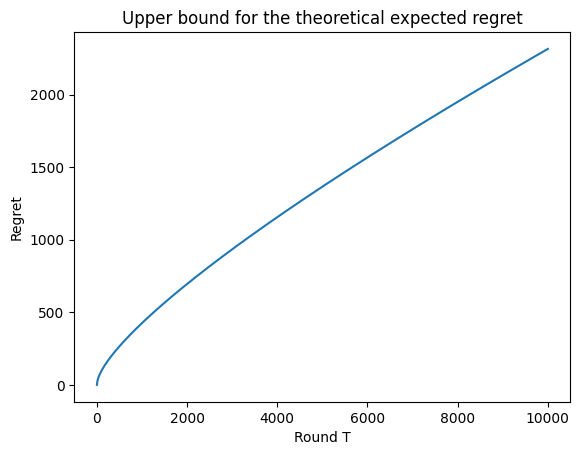

In [18]:
#plt.plot(np.arange(1,T+1), regret[current_user], label=f'Article {user_types[current_user]}')
plt.plot(np.arange(1,T+1), regret_upper_bound, label=f'Upper Bound')
plt.title("Upper bound for the theoretical expected regret") 
plt.xlabel("Round T") 
plt.ylabel("Regret") 
plt.show()